In [15]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import metrics, preprocessing
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [16]:
#read data
data = pd.read_excel("C:\\Users\\Stefan\\Documents\\WeChat Files\\wxid_w8sj4o3djk4k22\\FileStorage\\File\\2023-06\\default of credit card clients.xls")
data.head()
data.shape

(30001, 25)

**Information**

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:<br>
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
X2: Gender (1 = male; 2 = female).<br>
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).<br>
X4: Marital status (1 = married; 2 = single; 3 = others).<br>
X5: Age (year).<br>
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.<br>
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. <br>
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



## Preprocess

### Convert Datatype from Object to Int

In [17]:
data=data.drop([0])

In [18]:
df = data.astype(int)
df.dtypes

Unnamed: 0    int32
X1            int32
X2            int32
X3            int32
X4            int32
X5            int32
X6            int32
X7            int32
X8            int32
X9            int32
X10           int32
X11           int32
X12           int32
X13           int32
X14           int32
X15           int32
X16           int32
X17           int32
X18           int32
X19           int32
X20           int32
X21           int32
X22           int32
X23           int32
Y             int32
dtype: object

In [19]:
df = df.drop(columns='Unnamed: 0')

### Delete Outliers

In [20]:
# df = df.drop(df[(df['X6']==0) | (df['X6']==-2)].index) 
# df = df.drop(df[(df['X7']==0) | (df['X7']==-2)].index)

In [21]:
df["X6"][df.X6<1]=-1
df["X7"][df.X7<1]=-1
df["X8"][df.X8<1]=-1
df["X9"][df.X9<1]=-1
df["X10"][df.X10<1]=-1
df["X11"][df.X11<1]=-1

In [22]:
df.shape

(30000, 24)

## Explore Dataset 

### Correlation Coefficients to default

In [23]:
df.corr()['Y'] #Show the correlation Coefficients to default

X1    -0.153520
X2    -0.039961
X3     0.028006
X4    -0.024339
X5     0.013890
X6     0.398636
X7     0.333438
X8     0.292026
X9     0.274779
X10    0.266465
X11    0.248252
X12   -0.019644
X13   -0.014193
X14   -0.014076
X15   -0.010156
X16   -0.006760
X17   -0.005372
X18   -0.072929
X19   -0.058579
X20   -0.056250
X21   -0.056827
X22   -0.055124
X23   -0.053183
Y      1.000000
Name: Y, dtype: float64

<Axes: >

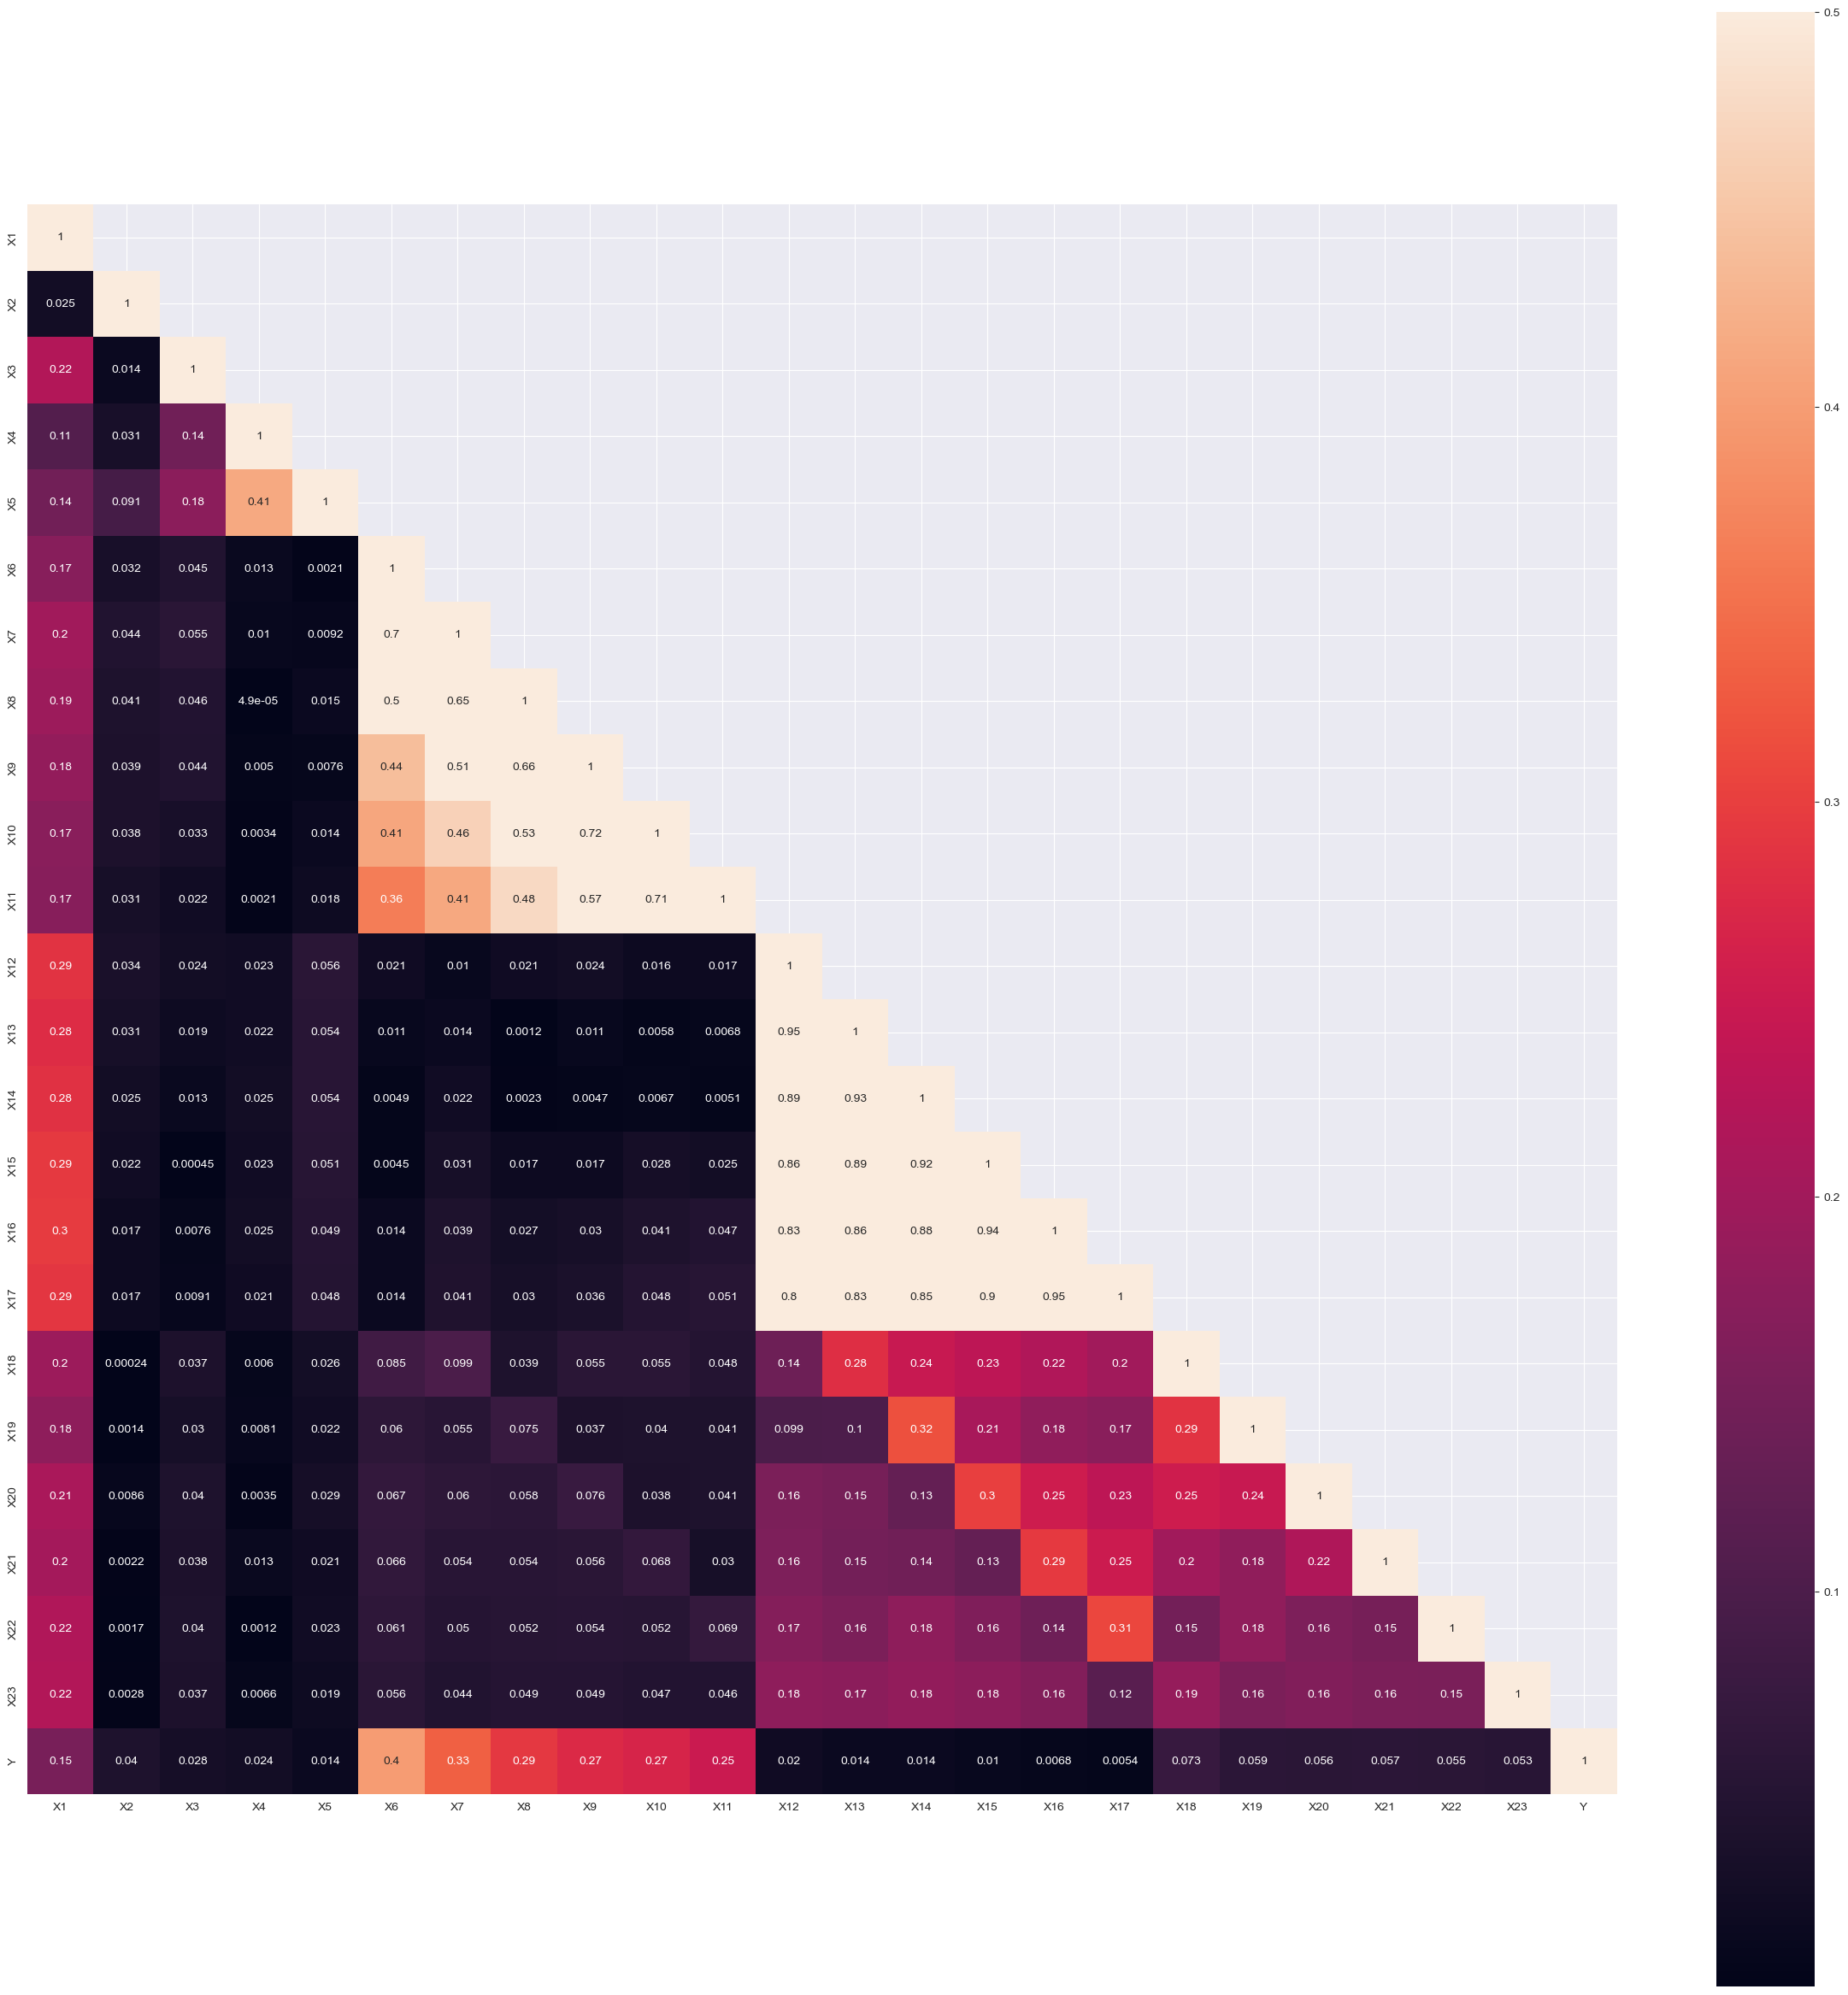

In [24]:
corr_matrix = df.corr().abs()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(30,30)
sns.heatmap(corr_matrix,mask=mask,vmax=.5,  square=True,annot=True)

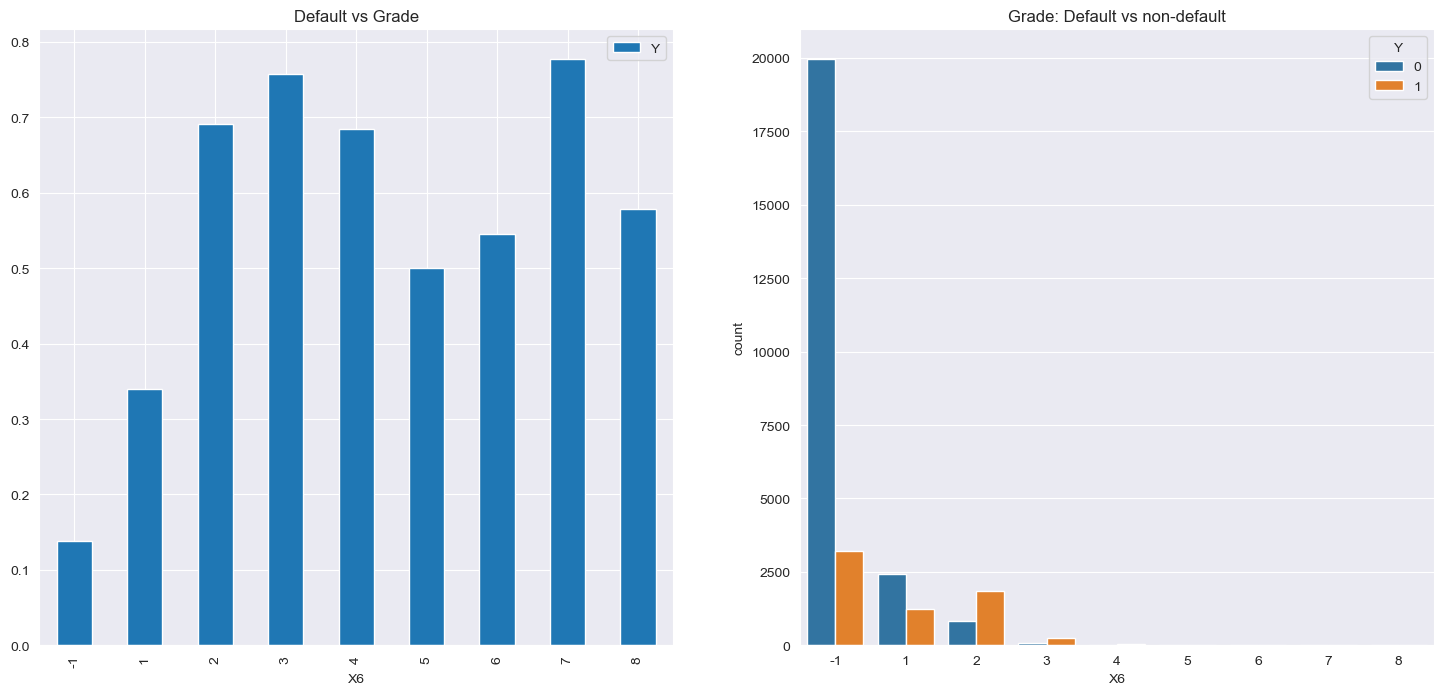

In [25]:
# Show default with grades
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['X6','Y']].groupby(['X6']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Default vs Grade')
sns.countplot(x= 'X6',hue='Y',data= df,ax=ax[1])
ax[1].set_title('Grade: Default vs non-default')
plt.show()

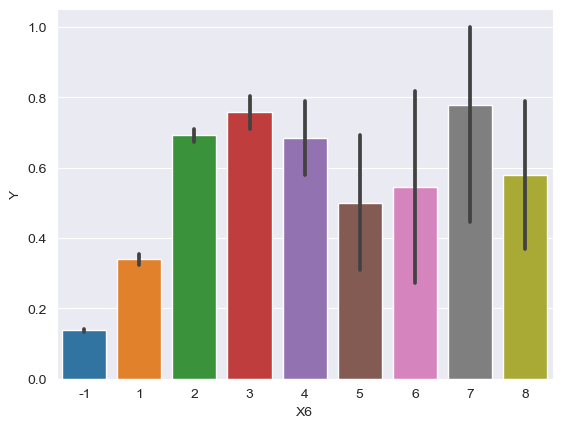

In [26]:
# Show the default ratio of different grades
grade_order=[-1,1,2,3,4,5,6,7,8]
sns.barplot(x='X6',y='Y',data=df,order=grade_order)
plt.show()

## Train with selected features (Not used, coz performs worse)

In [27]:
#importing all the required ML packages
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn import metrics #accuracy measure
from sklearn.linear_model import LinearRegression #LinearRegression
from sklearn.linear_model import LogisticRegression #LogisticRegression

In [28]:
# Put all selected features in a new dataset: data_model.
data_model= df[['X1', 'X6', 'X7', 'X8', 'X9','X10','X11','Y']]
data_model.head()

,X1,X6,X7,X8,X9,X10,X11,Y
1,20000,2,2,-1,-1,-1,-1,1
2,120000,-1,2,-1,-1,-1,2,1
3,90000,-1,-1,-1,-1,-1,-1,0
4,50000,-1,-1,-1,-1,-1,-1,0
5,50000,-1,-1,-1,-1,-1,-1,0


In [29]:
# Show basic information about data_model.
data_model.describe()

,X1,X6,X7,X8,X9,X10,X11,Y
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.415967,-0.532033,-0.555500,-0.624233,-0.679567,-0.670800,0.221200
std,129747.661567,1.142591,1.146393,1.126275,1.067522,1.001726,1.005283,0.415062
min,10000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,140000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,240000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000


In [30]:
# Divide the whole data to 2 parts, 80% as training set, 20% as test set
train,test=train_test_split(data_model,test_size=0.2,random_state=0,stratify=df['Y'])

train_X=train[train.columns[:-1]]
train_y=train[train.columns[-1]]

test_X=test[test.columns[:-1]]
test_y=test[test.columns[-1]]

In [31]:
clf = LogisticRegression(random_state=0).fit(train_X, train_y)
print("The prediction values are: ",clf.predict(test_X))

The prediction values are:  [0 0 0 ... 1 0 0]


In [32]:
# Probability of defualt and non-defaultproba=clf.predict_proba(test_X) 
default_proba = []
for line in clf.predict_proba(test_X):
    default_proba.append(line[1])
    
print("The prediction default probabilities are: ",default_proba[0:5],'...')

The prediction default probabilities are:  [0.17417113832634745, 0.24582362221389595, 0.0602740886979731, 0.17417113832634745, 0.4274675117090058] ...


In [33]:
prediction3=clf.predict(test_X)
print("The prediction values are: ",prediction3)
print('The f1_score of the Logistuc Regression is',f1_score(prediction3,test_y,average='weighted'))


The prediction values are:  [0 0 0 ... 1 0 0]
The f1_score of the Logistuc Regression is 0.8306209024952308


## Logistic Regression（default）

In [34]:
# Divide the whole data to 2 parts, 80% as training set, 20% as test set
train,test=train_test_split(df,test_size=0.2,random_state=0,stratify=df['Y'])

train_X=train[train.columns[:-1]]
train_y=train[train.columns[-1]]

test_X=test[test.columns[:-1]]
test_y=test[test.columns[-1]]

In [35]:
#train_X.head()

In [36]:
#train_y.head()

In [37]:
clf = LogisticRegression(random_state=0).fit(train_X, train_y)
print("The prediction values are: ",clf.predict(test_X))

The prediction values are:  [0 0 0 ... 0 0 0]


In [38]:
# Probability of defualt and non-defaultproba=clf.predict_proba(test_X) 
default_proba = []
for line in clf.predict_proba(test_X):
    default_proba.append(line[1])
    
print("The prediction default probabilities are: ",default_proba[0:5],'...')

The prediction default probabilities are:  [0.3033171500002827, 0.15651353625325284, 0.007157930090337805, 0.3457511153088848, 0.3588977698527039] ...


In [39]:
prediction3=clf.predict(test_X)
print("The prediction values are: ",prediction3)
print('The f1_score of the Logistuc Regression is',f1_score(prediction3,test_y,average='weighted'))


The prediction values are:  [0 0 0 ... 0 0 0]
The f1_score of the Logistuc Regression is 0.875416291854073


In [40]:
flatten_data = prediction3.flatten()
list_data = flatten_data.tolist()
set_data = set(list_data)
set_data

{0, 1}

## Hyperparameter tuning

### Build Logistic Regression with Hyperparameter

In [41]:
logModel = LogisticRegression()

In [42]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

### Import Grid Search

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [46]:
best_clf = clf.fit(train_X,train_y)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


In [49]:
best_clf.best_estimator_

LogisticRegression(C=0.004832930238571752, penalty='l1', solver='liblinear')